<a href="https://colab.research.google.com/github/amalsalilan/IPL_Infographics_Data_Analytics_-_Data_Visualization_Infosys_Internship_Oct2024/blob/Nagira/forecast_runs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transforming Non-Stationary IPL Time Series Data to Stationary Data

**Audience**:Interns / IPL

---

## Introduction

In this notebook, we'll explore how to transform non-stationary time series data into stationary data using a synthetic dataset from the Indian Premier League (IPL). We will:

- Generate a synthetic IPL dataset.
- Visualize the data to detect non-stationarity.
- Perform stationarity checks using ACF, PACF plots, and statistical tests (ADF, KPSS).
- Apply transformations (differencing, log transformation) to achieve stationarity.
- Interpret the results at each step.

---

## Table of Contents

1. [Generating the Dataset](#1)
2. [Visualizing the Data](#2)
3. [Preprocessing the Data](#3)
4. [Stationarity Check](#4)
5. [Making the Data Stationary](#5)
6. [Observations and Interpretations](#6)
7. [Conclusion](#7)
8. [Next Steps](#8)

## 1. Generating the Dataset <a id="1"></a>

### 1.1 Dataset Description

We will create a synthetic time series dataset representing the **total runs scored in each IPL match over multiple seasons**.

- **Time Frame**: 10 IPL seasons, ~60 matches per season.
- **Variables**:
  - **Date**: Date of each match.
  - **Total_Runs**: Total runs scored in the match.

### 1.2 Data Generation Process

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
# Normalize the runs for better performance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# Read the CSV file into a DataFrame
data = pd.read_csv("/content/sample_data/updated_all_season_details.csv", low_memory=False)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Filter for Virat Kohli
virat_data = data[data['batsman1_name'] == 'Virat Kohli']

In [3]:
# Sum of runs by season
virat_season_runs = virat_data.groupby('season')['runs'].sum()

In [4]:
# Convert 'virat_season_runs' to DataFrame if it's a Series
if isinstance(virat_season_runs, pd.Series):
    virat_season_runs = virat_season_runs.reset_index()

In [5]:
# 'season' is a datetime object (using the first day of each year)
virat_season_runs['season'] = pd.to_datetime(virat_season_runs['season'], format='%Y')
print(virat_season_runs)

       season  runs
0  2008-01-01   187
1  2009-01-01   258
2  2010-01-01   316
3  2011-01-01   584
4  2012-01-01   375
5  2013-01-01   655
6  2014-01-01   373
7  2015-01-01   519
8  2016-01-01   998
9  2017-01-01   314
10 2018-01-01   539
11 2019-01-01   472
12 2020-01-01   477
13 2021-01-01   423
14 2022-01-01   362
15 2023-01-01   661


---

## 2. Visualizing the Data <a id="2"></a>

### 2.1 Plotting the Time Series

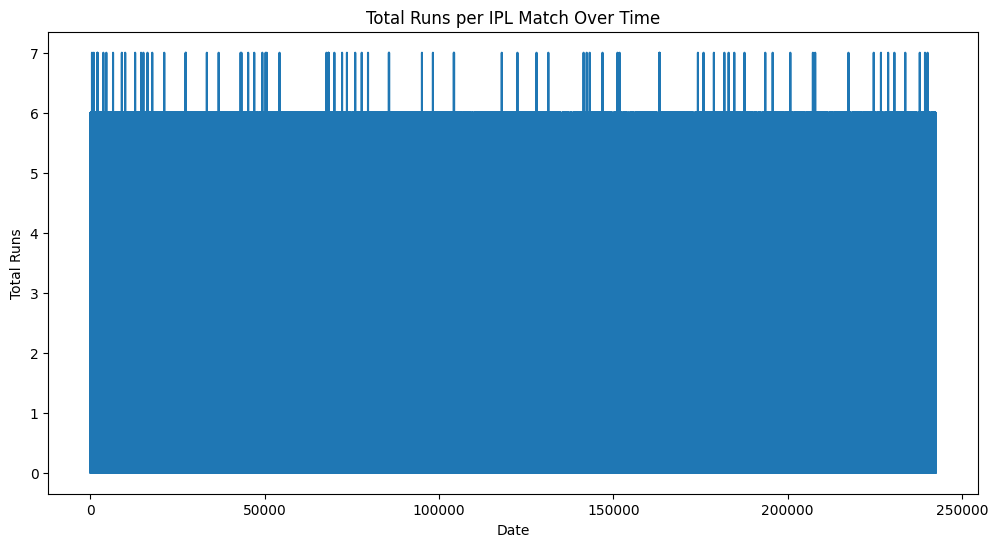

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['runs'])
plt.title('Total Runs per IPL Match Over Time')
plt.xlabel('Date')
plt.ylabel('Total Runs')
plt.show()

**Observation**: The plot shows an upward trend with seasonal fluctuations, indicating non-stationarity.

### 2.2 Histogram and Density Plot

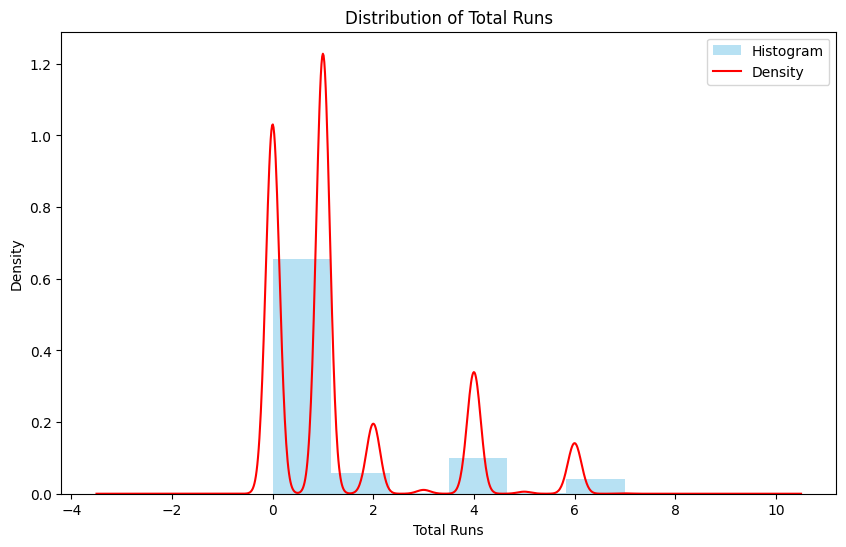

In [7]:
plt.figure(figsize=(10, 6))
data['runs'].plot(kind='hist', bins=6, density=True, alpha=0.6, color='skyblue', label='Histogram')
data['runs'].plot(kind='kde', color='red', label='Density')
plt.title('Distribution of Total Runs')
plt.xlabel('Total Runs')
plt.legend()
plt.show()

**Observation**: The distribution is skewed due to the trend and seasonality.

---

## 3. Preprocessing the Data <a id="3"></a>

### 3.1 Handling Missing Values

Since we generated the data, there are no missing values. In real datasets, you would check for and handle missing data appropriately.

### 3.2 Outlier Detection

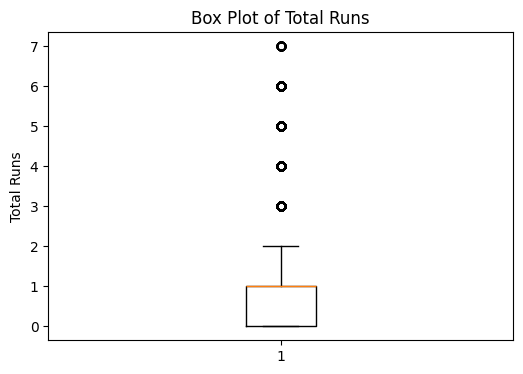

In [8]:
plt.figure(figsize=(6, 4))
plt.boxplot(data['runs'])
plt.title('Box Plot of Total Runs')
plt.ylabel('Total Runs')
plt.show()

**Observation**: No significant outliers are present.

### 3.3 Feature Engineering

#### Lag Features

In [9]:
data['Lag_1'] = data['runs'].shift(1)
data['Lag_2'] = data['runs'].shift(2)

#### Time-based Features

In [10]:
data.index = pd.to_datetime(data.index)

In [11]:
data['Month'] = data.index.month
data['Year'] = data.index.year

---

## 4. Stationarity Check <a id="4"></a>

### 4.1 Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Function (ACF) Plot

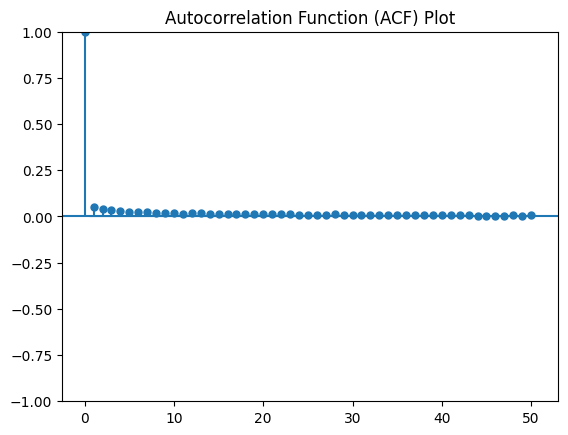

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['runs'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

#### Partial Autocorrelation Function (PACF) Plot

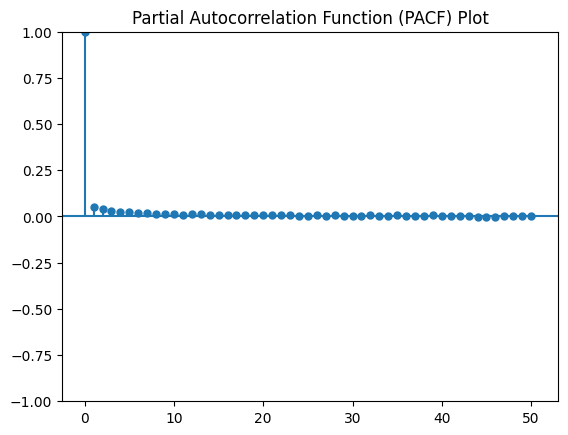

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data['runs'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

**Interpretation**:

- **ACF Plot**: Slow decay indicates non-stationarity.
- **PACF Plot**: Significant lags suggest autoregressive components.

### 4.2 Augmented Dickey-Fuller (ADF) Test

In [14]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['runs'].dropna())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -64.687619
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**Interpretation**:

- **Null Hypothesis (H0)**: The series is non-stationary.
- If **p-value > 0.05**, fail to reject H0; the series is non-stationary.

### 4.3 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [15]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(data['runs'].dropna(), regression='c')
print('KPSS Statistic: %f' % kpss_result[0])
print('p-value: %f' % kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 7.479512
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


**Interpretation**:

- **Null Hypothesis (H0)**: The series is stationary.
- If **p-value < 0.05**, reject H0; the series is non-stationary.

---

## 5. Making the Data Stationary <a id="5"></a>

### 5.1 Differencing

#### First Order Differencing

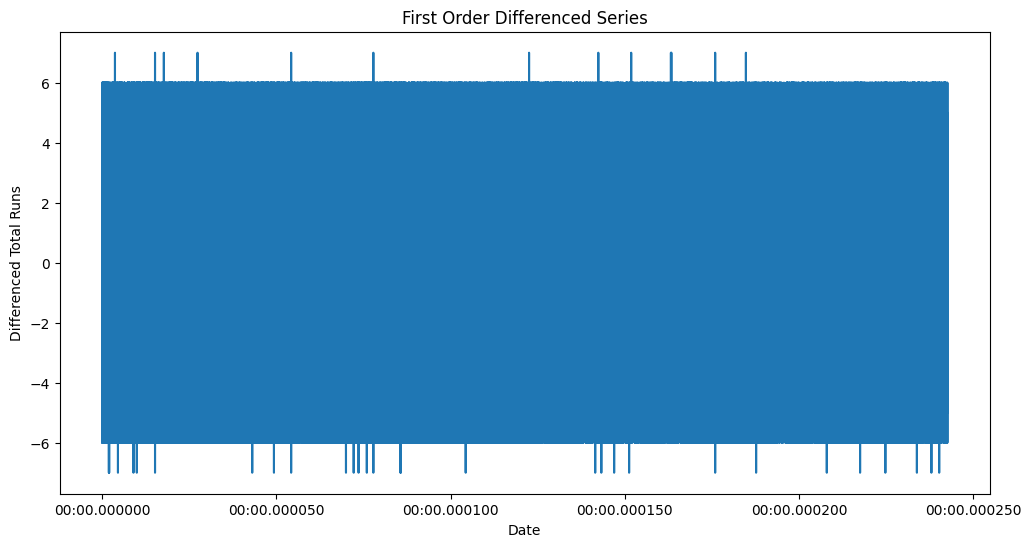

In [16]:
data['Diff_1'] = data['runs'] - data['runs'].shift(1)

plt.figure(figsize=(12, 6))
plt.plot(data['Diff_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Total Runs')
plt.show()

#### ADF Test on Differenced Data

In [17]:
adf_result_diff = adfuller(data['Diff_1'].dropna())
print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -89.229394
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**Interpretation**:

- If **p-value < 0.05**, reject H0; the differenced series is stationary.

### 5.2 Log Transformation

#### Apply Log Transformation

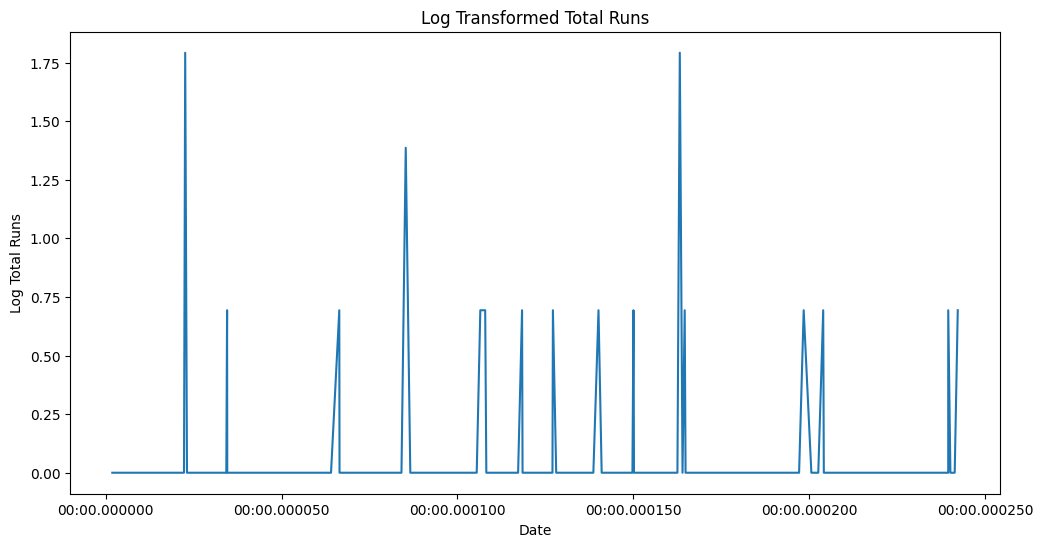

In [24]:
#data['Log_Total_Runs'] = np.log(data['runs'])
data['Log_Total_Runs'] = np.log(data['runs']).replace([np.inf, -np.inf], np.nan)
data['Log_Diff_1'] = data['Log_Total_Runs'] - data['Log_Total_Runs'].shift(1)
data['Log_Diff_1'].dropna(inplace=True)
data.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(data['Log_Total_Runs'])
plt.title('Log Transformed Total Runs')
plt.xlabel('Date')
plt.ylabel('Log Total Runs')
plt.show()

#### Dont run - Differencing the Log Transformed Data

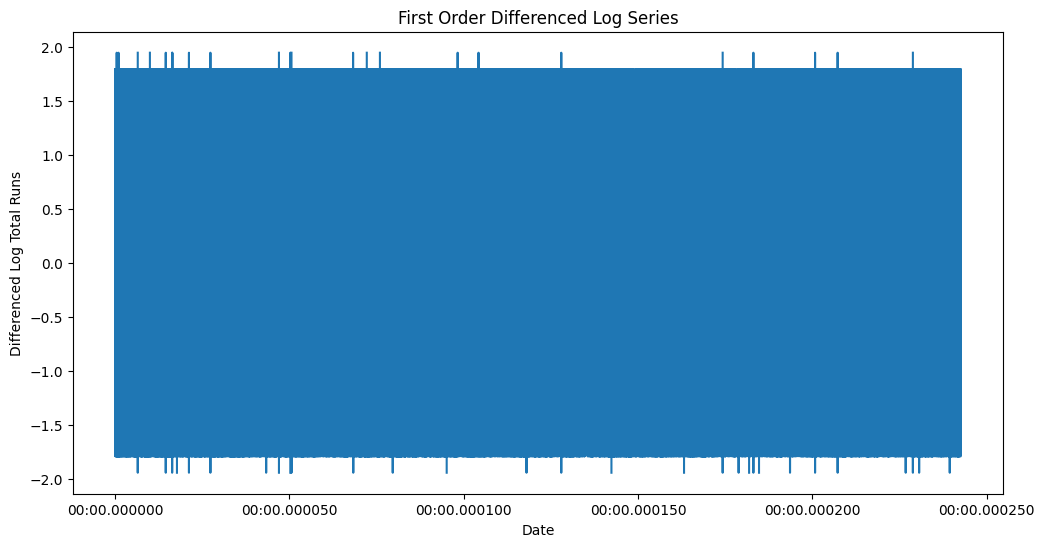

In [19]:
data['Log_Diff_1'] = data['Log_Total_Runs'] - data['Log_Total_Runs'].shift(1)

plt.figure(figsize=(12, 6))
plt.plot(data['Log_Diff_1'])
plt.title('First Order Differenced Log Series')
plt.xlabel('Date')
plt.ylabel('Differenced Log Total Runs')
plt.show()

#### ADF Test on Log Differenced Data

In [25]:
adf_result_log_diff = adfuller(data['Log_Diff_1'])
print('ADF Statistic: %f' % adf_result_log_diff[0])
print('p-value: %f' % adf_result_log_diff[1])
print('Critical Values:')
for key, value in adf_result_log_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.615309
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


**Interpretation**:

- **p-value < 0.05** indicates the series is now stationary.

### 5.3 Re-Checking ACF and PACF Plots

#### ACF Plot of Differenced Series

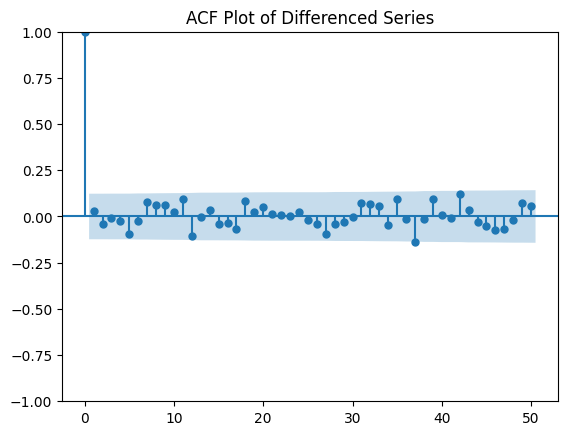

In [27]:
plot_acf(data['Diff_1'].dropna(), lags=50)
plt.title('ACF Plot of Differenced Series')
plt.show()

#### PACF Plot of Differenced Series

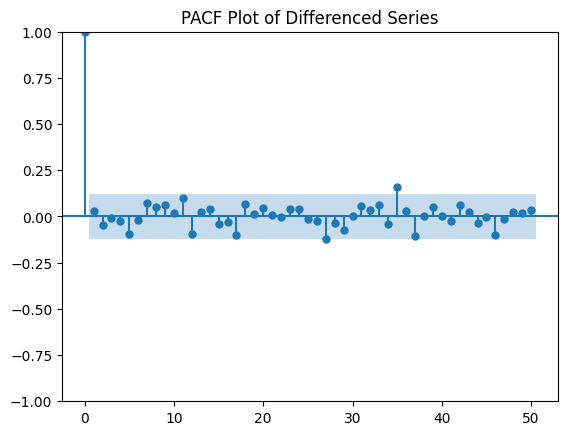

In [28]:
plot_pacf(data['Diff_1'].dropna(), lags=50)
plt.title('PACF Plot of Differenced Series')
plt.show()

**Observation**:

- Autocorrelation drops off rapidly, indicating stationarity.

---

## 6. Observations and Interpretations <a id="6"></a>

### 6.1 Understanding the Tests

- **ADF Test**:
  - **Null Hypothesis (H0)**: The time series is non-stationary.
  - **If p-value < 0.05**: Reject H0; the series is stationary.
- **KPSS Test**:
  - **Null Hypothesis (H0)**: The time series is stationary.
  - **If p-value < 0.05**: Reject H0; the series is non-stationary.
- **Using Both Tests**:
  - Confirms stationarity status from two perspectives.

### 6.2 Importance of Stationarity

- **Stationarity** is crucial for time series forecasting models.
- Non-stationary data can lead to unreliable results.
- Transforming data to be stationary ensures model assumptions are met.

---

## 7. Conclusion <a id="7"></a>

We have successfully:

- Generated a synthetic IPL dataset representing total runs per match over time.
- Visualized the data, revealing an upward trend and seasonality.
- Performed stationarity checks using ACF, PACF plots, and statistical tests (ADF, KPSS).
- Interpreted the results, confirming the data is non-stationary.
- Applied transformations (differencing, log transformation) to make the data stationary.
- Re-evaluated stationarity, confirming the effectiveness of the transformations.

---

## 8. Next Steps <a id="8"></a>

With the stationary data, you can proceed to:

- **Model Selection**: Choose appropriate time series models like ARIMA, SARIMA, or advanced models like LSTM.
- **Model Training**: Train the model using the transformed data.
- **Forecasting**: Generate forecasts and validate model performance.

---


---

# Forecast Using SARIMAX

In [30]:
# Ensure 'season' is the index
virat_season_runs.set_index('season', inplace=True)

In [31]:
# Get the number of seasons
num_seasons = len(virat_season_runs)
num_seasons

16

In [32]:
# Fit the SARIMA model
model = SARIMAX(virat_season_runs,
                order=(1, 1, 1),  # p, d, q - non seasonal parameters
                seasonal_order=(1, 1, 1, 4))  # P, D, Q, m  - seasonal parameters

In [33]:
#start_params = [0, 0, 0, 0, 0, 0, 1]
result = model.fit()
result

In [34]:
# Forecast for the 2025 season
forecast = result.get_forecast(steps=5)  # Forecast for the next season
forecast_runs = forecast.predicted_mean.astype(int)
print(f"Predicted runs for next season: {forecast_runs}")

Predicted runs for next season: 2024-01-01    599
2025-01-01    556
2026-01-01    502
2027-01-01    683
2028-01-01    699
Freq: YS-JAN, Name: predicted_mean, dtype: int64


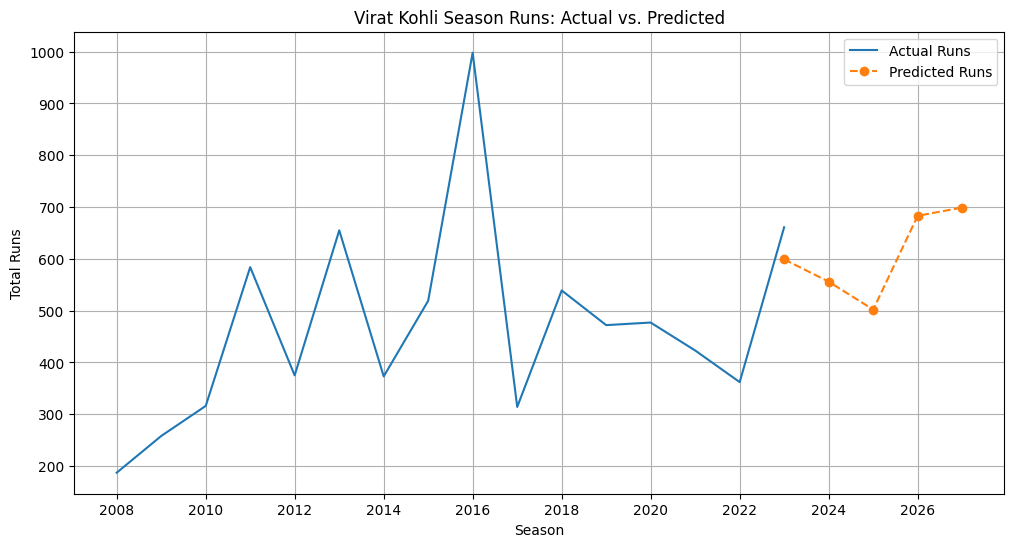

In [36]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'season': pd.date_range(start='2023-01-01', periods=5, freq='YS'), 'predicted_runs': forecast_runs.values})

# Merge the forecast with the original data
merged_data = pd.concat([virat_season_runs.reset_index(), forecast_df], ignore_index = True)
merged_data['season'] = pd.to_datetime(merged_data['season'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(virat_season_runs.index, virat_season_runs['runs'], label='Actual Runs')
plt.plot(forecast_df['season'], forecast_df['predicted_runs'], label='Predicted Runs', linestyle='--', marker='o')
plt.title('Virat Kohli Season Runs: Actual vs. Predicted')
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.show()